In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Importations
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader, BatchSampler, random_split
from itertools import chain

from src.covid_cytof_dataset import CovidCytofDataset
from src.models.configurable_nn import ConfigurableNeuralNetwork
from src.models.simple_nn import SimpleNeuralNetwork
from src.trainer import Trainer

sns.set_theme()

In [3]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
# device = "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
NUM_CELLS_PER_PATIENTS = 10000
BATCH_SIZE = 100

In [5]:
data = CovidCytofDataset("./data/attachments/COVID_CYTOF_BASIC_METADATA_STATUS_AGE_GROUP_SEX.xlsx", "./data",
                         NUM_CELLS_PER_PATIENTS)

/home/evann/.cache/pypoetry/virtualenvs/covid-cytof-NoJZp_V7-py3.10/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Loading fcs data:


100%|██████████| 99/99 [00:26<00:00,  3.75it/s]


done


In [6]:
# train_data, test_data = random_split(list(BatchSampler(data, batch_size=NUM_CELLS_PER_PATIENS, drop_last=False)),
#                                      [0.8, 0.2])
# train_data, test_data = list(chain.from_iterable(train_data)), list(chain.from_iterable(test_data))

train_data, test_data = random_split(data, [0.8, 0.2])

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [18]:
model = SimpleNeuralNetwork(data.data.shape[1], 500, 1).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

trainer = Trainer(model, optimizer, loss_fn, device, epochs=30)
trainer.run(train_dataloader, test_dataloader)

trainer.plot_loss()
trainer.plot_accuracy()
trainer.plot_f1()

SimpleNeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=61, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
----- Epoch 1 -----
loss: 0.250157  [  100/79200]
Test set: Average loss: 0.2116, Accuracy: 13778/19800 (70%)
----- Epoch 2 -----
loss: 0.189152  [  100/79200]
Test set: Average loss: 0.2082, Accuracy: 13778/19800 (70%)
----- Epoch 3 -----
loss: 0.202599  [  100/79200]
Test set: Average loss: 0.2061, Accuracy: 13778/19800 (70%)
----- Epoch 4 -----
loss: 0.215523  [  100/79200]
Test set: Average loss: 0.2042, Accuracy: 13778/19800 (70%)
----- Epoch 5 -----
loss: 0.211328  [  100/79200]
Test set: Average loss: 0.2025, Accuracy: 13778/19800 (70%)
----- Epoch 6 -----
loss: 0.198147  [  100/79200]
Test set: Average loss: 0.2010, Accuracy: 13778/19800 (70%)
----- Epoch 7 -----
loss: 0.211478  [  100/79200]
Test set: Average loss: 0.1996, Accuracy: 13777/19800 (70%)
----- Epoch 

----- Epoch 1 -----
loss: 0.266478  [  100/792000]
loss: 0.206505  [500100/792000]
Test set: Average loss: 0.2013, Accuracy: 139780/198000 (71%)
----- Epoch 2 -----
loss: 0.185485  [  100/792000]
loss: 0.184840  [500100/792000]
Test set: Average loss: 0.1899, Accuracy: 141018/198000 (71%)
----- Epoch 3 -----
loss: 0.201235  [  100/792000]
loss: 0.214136  [500100/792000]
Test set: Average loss: 0.1858, Accuracy: 141900/198000 (72%)
----- Epoch 4 -----
loss: 0.188436  [  100/792000]
loss: 0.190617  [500100/792000]
Test set: Average loss: 0.1836, Accuracy: 142731/198000 (72%)
----- Epoch 5 -----
loss: 0.151894  [  100/792000]
loss: 0.192052  [500100/792000]
Test set: Average loss: 0.1823, Accuracy: 143410/198000 (72%)


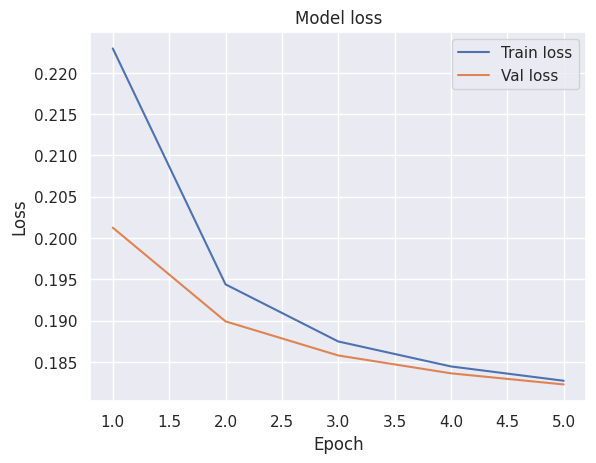

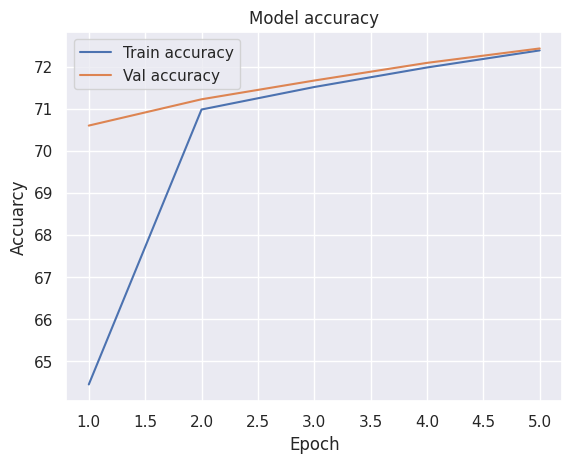

In [12]:
model1 = ConfigurableNeuralNetwork([
    data.data.shape[1],
    1
]).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=1e-3)

trainer = Trainer(model1, optimizer, loss_fn, device, epochs=5)
trainer.run(train_dataloader, test_dataloader)

trainer.plot_loss()
trainer.plot_accuracy()
trainer.plot_f1()

----- Epoch 1 -----
loss: 0.228071  [  100/792000]
loss: 0.201834  [500100/792000]
Test set: Average loss: 0.2022, Accuracy: 138014/198000 (70%)
----- Epoch 2 -----
loss: 0.174309  [  100/792000]
loss: 0.237836  [500100/792000]
Test set: Average loss: 0.1962, Accuracy: 138194/198000 (70%)
----- Epoch 3 -----
loss: 0.204710  [  100/792000]
loss: 0.213871  [500100/792000]
Test set: Average loss: 0.1915, Accuracy: 138995/198000 (70%)
----- Epoch 4 -----
loss: 0.214493  [  100/792000]
loss: 0.191709  [500100/792000]
Test set: Average loss: 0.1877, Accuracy: 139988/198000 (71%)
----- Epoch 5 -----
loss: 0.193211  [  100/792000]
loss: 0.180479  [500100/792000]
Test set: Average loss: 0.1844, Accuracy: 141262/198000 (71%)
----- Epoch 6 -----
loss: 0.209663  [  100/792000]
loss: 0.188662  [500100/792000]
Test set: Average loss: 0.1817, Accuracy: 142786/198000 (72%)
----- Epoch 7 -----
loss: 0.190032  [  100/792000]
loss: 0.174441  [500100/792000]
Test set: Average loss: 0.1794, Accuracy: 14421

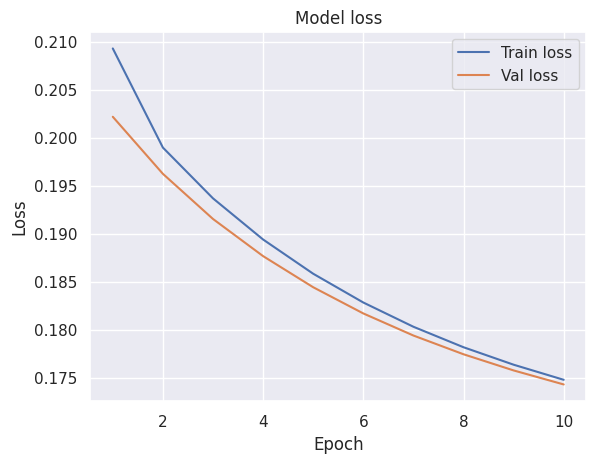

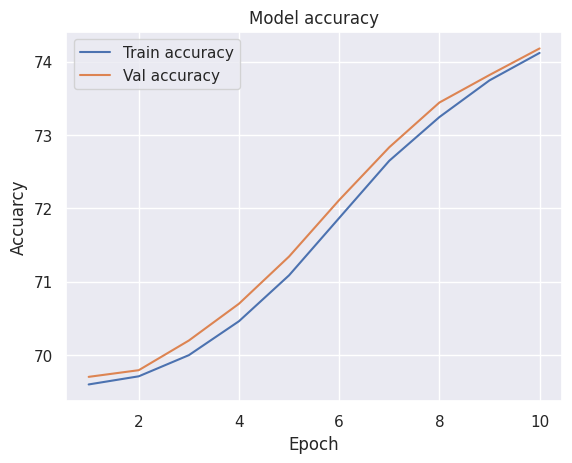

In [10]:
model2 = ConfigurableNeuralNetwork([
    data.data.shape[1],
    100,
    1
]).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=1e-3)

trainer = Trainer(model2, optimizer, loss_fn, device, epochs=10)
trainer.run(train_dataloader, test_dataloader)

trainer.plot_loss()
trainer.plot_accuracy()
trainer.plot_f1()

----- Epoch 1 -----
loss: 0.361969  [  100/792000]
loss: 0.182008  [500100/792000]
Test set: Average loss: 0.2102, Accuracy: 138014/198000 (70%)
----- Epoch 2 -----
loss: 0.232992  [  100/792000]
loss: 0.238260  [500100/792000]
Test set: Average loss: 0.2064, Accuracy: 138014/198000 (70%)
----- Epoch 3 -----
loss: 0.222059  [  100/792000]
loss: 0.245501  [500100/792000]
Test set: Average loss: 0.2027, Accuracy: 138018/198000 (70%)
----- Epoch 4 -----
loss: 0.198348  [  100/792000]
loss: 0.243778  [500100/792000]
Test set: Average loss: 0.1997, Accuracy: 138096/198000 (70%)
----- Epoch 5 -----
loss: 0.224312  [  100/792000]
loss: 0.180468  [500100/792000]
Test set: Average loss: 0.1970, Accuracy: 138228/198000 (70%)
----- Epoch 6 -----
loss: 0.176244  [  100/792000]
loss: 0.202177  [500100/792000]
Test set: Average loss: 0.1946, Accuracy: 138408/198000 (70%)
----- Epoch 7 -----
loss: 0.232932  [  100/792000]
loss: 0.192507  [500100/792000]
Test set: Average loss: 0.1927, Accuracy: 13860

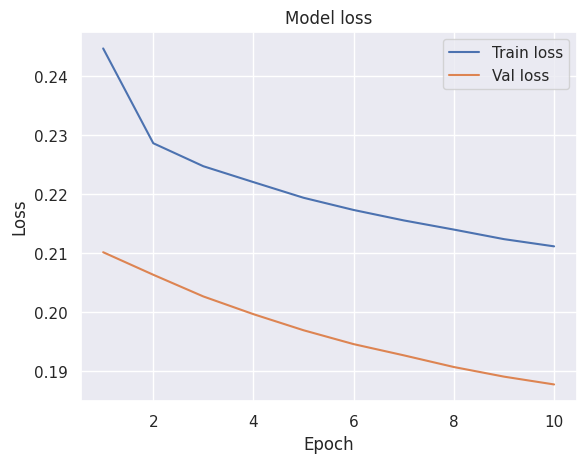

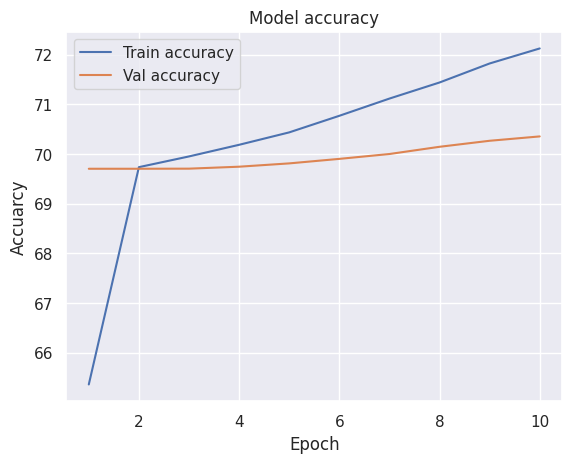

In [11]:
model2_dropout = ConfigurableNeuralNetwork([
    data.data.shape[1],
    100,
    1
], dropout=0.25).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model2_dropout.parameters(), lr=1e-3)

trainer = Trainer(model2_dropout, optimizer, loss_fn, device, epochs=10)
trainer.run(train_dataloader, test_dataloader)

trainer.plot_loss()
trainer.plot_accuracy()
trainer.plot_L1()